In [24]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

/tmp/ipykernel_288474/3777615979.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [25]:
# IMPORT
import numpy as np
import numpy.ma as ma
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from netCDF4 import Dataset
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import xarray as xr
import glob
from datetime import datetime, timedelta
from numba import jit


@jit()
def rms(true,prediction):
    return np.sqrt(np.nanmean((prediction-true)**2))

@jit()
def mean_error(true,prediction):
    return np.nanmean(prediction - true)

@jit()
def rms_tendency(variable,hours):
    variable_tendency = np.zeros((hours))
    variable = np.exp(variable) * 1000.0
    for i in range(hours):
        variable_tendency[i] = np.sqrt(np.mean((variable[i+1] - variable[i])**2.0))
    return variable_tendency

def latituded_weighted_rmse(true,prediction,lats):
    diff = prediction-true
    weights = np.cos(np.deg2rad(lats))
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff**2.0
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
    weighted_average = np.ma.average(masked,weights=weights2d)
    return np.sqrt(weighted_average)

def latituded_weighted_bias(true,prediction,lats):
    diff = prediction-true
#     print(diff[0])
    weights = np.cos(np.deg2rad(lats))
#     print(weights[0])
    weights2d = np.zeros(np.shape(diff))
    diff_squared = diff
    #weights = np.ones((10,96))
    weights2d = np.tile(weights,(96,1))
    weights2d = np.transpose(weights2d)
#     print(weights2d)
    masked = np.ma.MaskedArray(diff_squared, mask=np.isnan(diff_squared))
#     print(masked[0])
    weighted_average = np.ma.average(masked,weights=weights2d)
#     print(weighted_average)
    return weighted_average




In [33]:
## MAIN SCRIPT
## **** CHANGE FILES AND DATES HERE

def rmse_time_series_plot_and_maps(level_in_speedy,variable_speedy):
    # Define: Initial FILES, dates, Variable, and Level desired

#     analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
#     analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_3_40MEM_individual_ens_member_20110101_20110601/mean_output/out.nc'
    analysis_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/mean.nc'
    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_5_40MEM_individual_ens_member_20110101_20110601/mean_output_gues/out.nc'

    ## ERA5 crash tests
    # analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights_MEM1_eq_MEM2/mean_output/out.nc'
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_crash_ens_members_test/mean_output/out.nc'

    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/TROY_ERA5_RESULTS_TEST2/mean_output/out.nc'
#     analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/iterative1_speedystatesfixed_offbyonebugfixed_hybrid_1_5_1_3/mean.nc'
    ### THIS IS THE OLD Hybrid MEAN 1.3,1.3 ## BEFORE BUGG FIXES
    #analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal/mean/mean.nc'
    '''
    
    
    ANAL
    
    
    '''
    ### ERA5  
    analysis_file = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/mean_output/out.nc'
    

    spread_file_ERA5 = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_1_3_6hr_timestep_1_24_24_20110101_20120101/sprd_output/out.nc'
    
    
    spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/speedy_cov_1_3_40MEM_individual_ens_member_20110101_20110601/sprd_output/out.nc'
#     spread_file_speedy = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_speedy_covar1_3_20110101_20120901/sprd.nc' 
    
    # SPREAD FILES
    ds_spread_ERA5 = xr.open_dataset(spread_file_ERA5)
    ds_spread_speedy = xr.open_dataset(spread_file_speedy)
    

    start_year = 2011
    end_year = 2011

    startdate = datetime(2011,1,1,0)
    enddate = datetime(2011,12,31,18)
    time_slice = slice(startdate,enddate)

    #level = 0.95 #0.2#0.95#0.51
    #level_era = 7 #2#7 #4
    
    level = level_in_speedy
    if level_in_speedy == .95:
        level_in_era = 7
    if level_in_speedy == .2:
        level_in_era = 2
    level_era = level_in_era

    var_da = variable_speedy
    if variable_speedy == 'q':
        variable_era = 'Specific_Humidity'
    if variable_speedy == 't':
        variable_era = 'Temperature'
    if variable_speedy == 'v':
        variable_era = 'V-wind'
    if variable_speedy == 'u':
        variable_era = 'U-wind'
    if variable_speedy == 'ps':
        variable_era = 'logp'
        
    
#     var_era = variable_era
    print(variable_era)
    var_era = variable_era

    #var_era = 'V-wind'#'Specific_Humidity'#'Temperature' #'V-wind'
    #var_da =  'v'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    


    # create empty list to store indiviudal datasets
    era5sets = []
    print('made it to the for loop...')

    # LOAD DATA HERE 
    print('LOADING DATA...')
    # FOR ERA5
    timestep_6hrly = 6
    # loop over the range of years and open each ds
    for year in range(start_year, end_year + 1):
        nature_file = f'/skydata2/troyarcomano/ERA_5/{year}/era_5_y{year}_regridded_mpi_fixed_var.nc'
        # only load var_era selected and only load level_era selected from above
        if variable_speedy == 'ps': # don't select level if variable is 'ps'
            ds_nature = xr.open_dataset(nature_file)[var_era]
        else:
            ds_nature = xr.open_dataset(nature_file)[var_era].sel(Sigma_Level=level_era)
        # Read in every 6th timestep
        ds_nature = ds_nature.isel(Timestep=slice(None, None, timestep_6hrly))
        era5sets.append(ds_nature)

    print('Now its concatinating them all together...')

    ds_nature = xr.concat(era5sets, dim = 'Timestep')
    ds_nature = ds_nature.sortby('Timestep')
    print('Done concat and sortby Timestep...')
#     temp_500_nature = ds_nature.values

    # if surface pressure variable selected, then don't select a level. Theres only one for surface pressure..
    if var_era == 'logp':
        #convert to hPa for era5 ds
        temp_500_nature = np.exp(ds_nature.values) * 1000.0
        #convert to hPa for letkf analysis                         
        ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(time=time_slice) / 100.0
        ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(time=time_slice).values / 100.0
    else:     
        temp_500_nature = ds_nature.values
        ds_analysis_mean = xr.open_dataset(analysis_file)[var_da].sel(lev=level,time=time_slice)
        ds_analysis_mean_speedy = xr.open_dataset(analysis_file_speedy)[var_da].sel(lev=level,time=time_slice)

    temp_500_analysis = ds_analysis_mean
    # temp_500_analysis = ds_analysis_mean[var_da].sel(lev=level).values
    temp_500_analysis_speedy = ds_analysis_mean_speedy
    # temp_500_analysis_speedy = ds_analysis_mean_speedy[var_da].sel(lev=level,time=time_slice).values
    
    
#     temp_500_spread_era5 = ds_spread_ERA5[var_da].sel(lev=level).values
#     temp_500_spread_speedy = ds_spread_speedy[var_da].sel(lev=level).values
    


    print('era5 shape = ',np.shape(temp_500_nature))
    print('speedy shape = ',np.shape(temp_500_analysis_speedy))
    print('hybrid shape = ',np.shape(temp_500_analysis))

    #find smallest index value to set that as the "length"
    speedy_index = temp_500_analysis_speedy.shape[0]
    nature_index = temp_500_nature.shape[0]
    hybrid_index = temp_500_analysis.shape[0]
    smallest_index = min(speedy_index,nature_index,hybrid_index)

    if smallest_index == speedy_index:
        length = speedy_index #- 1
    elif smallest_index == nature_index:
        length = nature_index
    else:
        length = hybrid_index
    print('the smallest length is',length)
    
    #ps_nature = ds_nature['logp'].values
    #ps_nature = 1000.0 * np.exp(ps_nature)
    #ps_analysis = ds_analysis_mean['ps'].values/100.0

    xgrid = 96
    ygrid = 48
    #length =365*4*2 #1952-7 # 240 for 3 months  #1450 ##338 #160#64#177#1400#455

    analysis_rmse = np.zeros((length))
    analysis_rmse_speedy = np.zeros((length))
    global_average_ensemble_spread_era5 = np.zeros((length))
    global_average_ensemble_spread_speedy = np.zeros((length))
    #ps_rmse = np.zeros((length))

    analysis_error = np.zeros((length,ygrid,xgrid))
    analysis_error_speedy = np.zeros((length,ygrid,xgrid))
    
    analysis_bias = np.zeros((length))
    analysis_bias_speedy = np.zeros((length))

    print(np.shape(analysis_error))
    print(np.shape(analysis_error_speedy))
    
    print('Test unit check:')
    print(ds_analysis_mean[0])

    print('Now its calculating analysis RMSE...')
    lats = ds_nature.Lat
    
    
    for i in range(length):
#         analysis_rmse[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
#         analysis_rmse_speedy[i] = latituded_weighted_rmse(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        #ps_rmse[i] = rms(ps_nature[i*6,:,:],ps_analysis[i,:,:])
    
        analysis_error[i,:,:] = temp_500_analysis[i,:,:] - temp_500_nature[i,:,:]
        analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]
        
        analysis_bias[i] = latituded_weighted_bias(temp_500_nature[i,:,:],temp_500_analysis[i,:,:],lats)
        analysis_bias_speedy[i] = latituded_weighted_bias(temp_500_nature[i,:,:],temp_500_analysis_speedy[i,:,:],lats)
        
#         global_average_ensemble_spread_era5[i] = np.average(temp_500_spread_era5[i,:,:])
#         global_average_ensemble_spread_speedy[i] = np.average(temp_500_spread_speedy[i,:,:])

    # print('mean analysis_rmse = ',analysis_rmse)

    print('DONE CALCULATING ERROR AT EVERY GRIDPOINT AT EVERY TIMESTEP.')
    
    ############################
    # LOAD TROYS MEAN ANAL

    # Define the base path for the files
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/40member_hybrid_20110101_2011052906/anal'
    # base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/era5_28_yr_trained_weights/'

    ### ERA 5 crash test
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/'
#     troy_anal_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/troy_test_speedy_trained_12monthrun/mean_output/out.nc'
    ### ERA5 1 year run worked path
#     base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/ERA5_weights_sourcecodeupdated_1_20_24/'
    
    #### HYBRID NEW 1_3_1_3
    hybrid_base_path = '/skydata2/dylanelliott/letkf-hybrid-speedy/DATA/uniform_letkf_anal/hybrid_1_3_1_3_original_weights_20110101_20120101/'

    # Define the variable name, level, and time slice
    start_year = 2011
    end_year = 2011

    # startdate = datetime(2011,1,1,0)
    # enddate = datetime(2011,6,1,0)
    time_slice = slice(startdate,enddate)

    # level = 0.95 #0.2#0.95#0.51
    # level_era = 7 #2#7 #4

    # var_era = 'Temperature'#'Specific_Humidity'#'Temperature' #'V-wind'
    # var_da =  't'#'q'#'t'#'v'
    print('you selected for variable =',var_era)
    print('at level =',level)
    
    ## ADDING MEAN of Hybrid
    path_mean_anal_hybrid_retest = hybrid_base_path + 'mean_output/out.nc'
    if variable_speedy == 'ps':
        ds_mean_anal_hybrid_retest_1_3_1_3 = xr.open_dataset(path_mean_anal_hybrid_retest)[var_da].sel(time=time_slice) / 100.0
    else:    
        ds_mean_anal_hybrid_retest_1_3_1_3 = xr.open_dataset(path_mean_anal_hybrid_retest)[var_da].sel(lev=level, time=time_slice)

    # SPREAD OF HYBRID
#     spread_file_hybrid = hybrid_base_path + 'sprd_output/out.nc'
#     ds_spread_hybrid = xr.open_dataset(spread_file_hybrid)
#     temp_500_spread_hybrid = ds_spread_hybrid[var_da].sel(lev=level).values
#     global_average_ensemble_spread_hybrid = np.zeros((length))
    
#     # Create an empty list to store the datasets
#     ds_list = []

#     # ens member list
#     ens_member_list = range(1,40+1)
# #     print("opening all files...")
#     # Loop through the member numbers and read in the corresponding files
#     for member_number in ens_member_list:
#         file_path = f'{base_path}/{member_number:03d}_output/out.nc'
#         # file_path = f'{base_path}/{member_number:03d}_output/{member_number:03d}.nc'
#         ds = xr.open_dataset(file_path)[var_da].sel(lev=level, time=time_slice)
#         ds_list.append(ds)
#     print('shape test =', np.shape(ds_list))
    
    
    
#     ds_anal_troy = xr.open_dataset(troy_anal_path)[var_da].sel(lev=level, time=time_slice)
#     print('shape test =', np.shape(ds_anal_troy))
    
    # print('ds_list[0] =',ds_list[0])

    # Assign each element in ds_list to be called ds_member_{i}
    # for i, ds in enumerate(ds_list, start=1):
    #     globals()[f'ds_member_{i}'] = ds

    # print(ds_member_1) 

    lats = ds_nature.Lat

    # analysis_error is for maps, see its a 3d array, 
    # MAKING analysis_rmse now

    print('MAKING zeros arrays..')
#     quantity_of_ens_members = 40
#     analysis_rmse_object = np.zeros((quantity_of_ens_members, length))
    
#     anal_rmse_troy = np.zeros((length))
#     anal_error_troy = np.zeros((length,ygrid,xgrid))
    anal_mean_error_hybrid_1_3_1_3 = np.zeros((length,ygrid,xgrid))
    
    anal_mean_error_hybrid_1_3_1_3_speedy_as_truth = np.zeros((length,ygrid,xgrid))
    
    anal_mean_rmse_hybrid_1_3_1_3 = np.zeros((length))
    
    anal_bias_hybrid_1_3_1_3 = np.zeros((length))
    # check shape, yes they are equal and vibing
    # print('new = ',np.shape(analysis_rmse_object[0]))
    # print('old = ', np.shape(analysis_rmse_1))

#     print('looping through each ERA5 ens_member at every timestep..')
#     counter = 0
#     for member_number in range(0,40):
#         # loop through each timestep
#         counter = counter + 1
#         print('MEM counter = ',counter)
#         for l in range(length):
#     #     for l in range(length):
#             analysis_rmse_object[member_number,l] = latituded_weighted_rmse(temp_500_nature[l,:,:],ds_list[member_number][l,:,:],lats)
    
        
    ##### and calc for mem 1 with length == 3:
    # analysis_rmse_mem1 = latituded_weighted_rmse(temp_500_nature[3,:,:],ds_list[1][3,:,:],lats)
    # print(analysis_rmse_mem1)
    #####

    # print('analysis_rmse_object[0] =',analysis_rmse_object[0])
    # print('analysis_rmse_object[39] =',analysis_rmse_object[39])    
    print('Calc hybrid analysis_error and bias')
    
    for i in range(length):
        # ERA5 as truth
        anal_mean_error_hybrid_1_3_1_3[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
        
        anal_bias_hybrid_1_3_1_3[i] = latituded_weighted_bias(temp_500_nature[i,:,:],ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:],lats)
        
        # Speedy as truth
        anal_mean_error_hybrid_1_3_1_3_speedy_as_truth[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_analysis_speedy[i,:,:]
    
    print('Done with speedy trained hybrid analysis.')
    
    # take average of anal_bias_hybrid_1_3_1_3
    global_mean_anal_bias_hybrid_1_3_1_3 = np.average(anal_bias_hybrid_1_3_1_3[24::])
    
    print('global mean bias of speedy trained hybrid analysis = ', global_mean_anal_bias_hybrid_1_3_1_3)
    
    # take avg of speedy_anal_bias 
    global_mean_anal_bias_speedy = np.average(analysis_bias_speedy[24::])
    print('global mean bias of speedy analysis = ', global_mean_anal_bias_speedy)
    
#     if var_era == 'Specific_Humidity': #convert to g/kg
#         global_mean_anal_bias_hybrid_1_3_1_3 = global_mean_anal_bias_hybrid_1_3_1_3*1000
#         global_mean_anal_bias_speedy = global_mean_anal_bias_speedy*1000
        
    
    
    #########################################################
    # MAKE MAP FROM ABOVE 

    ''' 24(below) instead of 28 to cut transient event (ML spin up) out in first few weeks '''
    ####### WHICH AVGERAGE ERROR DO YOU WANT?? I want the analysis error of the mean ERA5
    if var_era == 'Temperature':
        units='(K)'
    if var_era == 'Specific_Humidity':
        units='(g/kg)'
    if var_era == 'V-wind':
        units='(m/s)'
    if var_era == 'U-wind':
        units='(m/s)'
    if var_era == 'logp':
        units='(hPa)' # converted above
    print(units)
    if level == .95:
        title_level = 'Low Level '
    if level == .2:
        title_level = '200 hPa '
    print(title_level)
    if var_era == 'Specific_Humidity':
        title_var_era = 'Specific Humidity'
    if var_era == 'V-wind':
        title_var_era = "Meridional Wind"
    if var_era == 'Temperature':
        title_var_era = 'Temperature'
    if var_era == 'U-wind':
        title_var_era = 'Zonal Wind'
    if var_era == 'logp':
        title_var_era = 'Surface Pressure'
    print(title_var_era)
    
    obs_network_file = '/skydata2/troyarcomano/letkf-hybrid-speedy/obs/networks/uniform.txt'
    network_ij = np.loadtxt(obs_network_file,skiprows=2,dtype=int)
    network_ij = network_ij - 1
    
    
    #### TAKING OUT ABSOLUTE VALUE 
#     averaged_error = np.average(abs(analysis_error[24::,:,:]),axis=0)
    
    averaged_error = np.average((analysis_error[24::,:,:]),axis=0)
    averaged_error_speedy = np.average((analysis_error_speedy[24::,:,:]),axis=0)
    

    # SeeeEEeee no abs value taken so its the bias
    
    lat = ds_analysis_mean.lat.values
    lon = ds_analysis_mean.lon.values  
#     lons2d, lats2d = np.meshgrid(lon,lat)

    print('Now plotting and meshing...')
    
    # data for plot Hybrid and Speedy Map
    if var_era == 'Specific_Humidity':
        cyclic_data, cyclic_lons = add_cyclic_point(averaged_error*1000, coord=lon)
        cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
    else: 
        cyclic_data, cyclic_lons = add_cyclic_point(averaged_error, coord=lon)
        cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    
    # data for plot difference 
    diff = averaged_error - averaged_error_speedy
    if var_era == 'Specific_Humidity':
        cyclic_data_diff, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
    else:
        cyclic_data_diff, cyclic_lons = add_cyclic_point(diff, coord=lon)
        
#     print('cyclic_data ', cyclic_data, np.shape(cyclic_data))
#     print('cyclic_lons ', cyclic_lons, np.shape(cyclic_lons))
    
    lons2d,lats2d = np.meshgrid(cyclic_lons,lat)

#     lons2d, lats2d = np.meshgrid(lon,lat)
    
    ## SET VMIN AND VMAX using old code
    if level == .95 and var_era == 'Temperature':
        adapted_range = np.arange(-5.05,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)

    if level == .2 and var_era == 'Temperature':
#         adapted_range = np.arange(0,.1,.001)
#         adapted_difference_range = np.arange(-.05,.05,.001)
        adapted_range = np.arange(-5.05,5.05,.05)
        adapted_difference_range = np.arange(-5,5,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
        
    if level == .95 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(-3,3,.05)
        adapted_difference_range = np.arange(-2,2,.001)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
        
    if level == .2 and var_era == 'Specific_Humidity':
        adapted_range = np.arange(-.1,.1,.001)
        adapted_difference_range = np.arange(-.05,.05,.001)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .2 and var_era == 'V-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .95 and var_era == 'V-wind':
        adapted_range = np.arange(-5,5,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .95 and var_era == 'U-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    if level == .2 and var_era == 'U-wind':
        adapted_range = np.arange(-10.05,10.05,.05)
        adapted_difference_range = np.arange(-2,2,.05)
        range_min = min(adapted_range)
        range_max = max(adapted_range)
        diff_min = min(adapted_difference_range)
        diff_max = max(adapted_difference_range)
    
    ## ERA5 trained Hybrid Map
    
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Bias '+ units)
#     axs[0].set_title('LETKF Analysis Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'ERA5 trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Bias '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
#     plt.tight_layout()
#     plt.show()
#     ###############
#     # data for plot Hybrid and Speedy Map
    
    
    averaged_error_speedyhybrid = np.average((anal_mean_error_hybrid_1_3_1_3[24::,:,:]),axis=0) # this is average at each grid point. all I need to do is subtract 1 number from all these

    
#     if var_era == 'Specific_Humidity':
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedyhybrid*1000, coord=lon)
#         cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy*1000, coord=lon)
#     else: 
#         cyclic_data, cyclic_lons = add_cyclic_point(averaged_error_speedyhybrid, coord=lon)
#         cyclic_data_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    
#     # data for plot difference 
#     diff = averaged_error_speedyhybrid - averaged_error_speedy
#     if var_era == 'Specific_Humidity':
#         cyclic_data_diff, cyclic_lons = add_cyclic_point(diff*1000, coord=lon)
#     else:
#         cyclic_data_diff, cyclic_lons = add_cyclic_point(diff, coord=lon)
        
# #     print('cyclic_data ', cyclic_data, np.shape(cyclic_data))
# #     print('cyclic_lons ', cyclic_lons, np.shape(cyclic_lons))
    
#     lons2d,lats2d = np.meshgrid(cyclic_lons,lat)
    
    
    
#      ## SPEEDY trained Hybrid Map
    
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Bias '+ units)
#     axs[0].set_title('LETKF Analysis Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'SPEEDY trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Bias '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
#     plt.tight_layout()
#     plt.show()
    
#     # VARIABILITY PLOT BELOW
#     # take global mean and subtract at every gridpoint
#     # here it is: latitude weighted -> global_mean_anal_bias_hybrid_1_3_1_3 
    
    
#     #global_mean_anal_bias_hybrid_1_3_1_3 = np.average(anal_bias_hybrid_1_3_1_3[24::])
# #     print('global mean bias of speedy trained hybrid analysis = ', global_mean_anal_bias_hybrid_1_3_1_3)
# #     # take avg of speedy_anal_bias 
# #     global_mean_anal_bias_speedy = np.average(analysis_bias_speedy[24::])
# #     print('global mean bias of speedy analysis = ', global_mean_anal_bias_speedy)
    
#     if var_era == 'Specific_Humidity':
#         cyclic_data_bias_global_mean_departure, cyclic_lons = add_cyclic_point((global_mean_anal_bias_hybrid_1_3_1_3*1000) - (averaged_error_speedyhybrid*1000), coord=lon)
#         cyclic_data_speedy_bias_global_mean_depature, cyclic_lons = add_cyclic_point((global_mean_anal_bias_speedy*1000)- (averaged_error_speedy*1000), coord=lon)
#     else: 
#         cyclic_data_bias_global_mean_departure, cyclic_lons = add_cyclic_point((global_mean_anal_bias_hybrid_1_3_1_3) - (averaged_error_speedyhybrid), coord=lon)
#         cyclic_data_speedy_bias_global_mean_depature, cyclic_lons = add_cyclic_point((global_mean_anal_bias_speedy)- (averaged_error_speedy), coord=lon)

#     # data for plot difference 
#     diff_variability = (global_mean_anal_bias_hybrid_1_3_1_3 - averaged_error_speedyhybrid) - (global_mean_anal_bias_speedy - averaged_error_speedy)
#     if var_era == 'Specific_Humidity':
#         cyclic_data_diff_variability, cyclic_lons = add_cyclic_point(diff_variability*1000, coord=lon)
#     else:
#         cyclic_data_diff_variability, cyclic_lons = add_cyclic_point(diff_variability, coord=lon)
        
#     ## SPEEDY trained Hybrid
#     fig, axs = plt.subplots(3, 1, figsize=(24, 10), subplot_kw={'projection': ccrs.PlateCarree()})
#     # Plot HYBRID
#     img1 = axs[0].imshow(cyclic_data_bias_global_mean_departure, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax= range_max, cmap='inferno', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[0].coastlines()
# #     axs[0].gridlines()
#     cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar1.set_label('Departure from Global Mean '+ units)
#     axs[0].set_title('LETKF Global Analysis Mean Bias - Analysis Gridpoint Mean Bias\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'SPEEDY trained Hybrid')

#     # Plot SPEEDY
#     img2 = axs[1].imshow(cyclic_data_speedy_bias_global_mean_depature, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = range_min, vmax=range_max, cmap='inferno', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[1].coastlines()
# #     axs[1].gridlines()
#     cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar2.set_label('Departure from Global Mean '+ units)  # Change label for Data 2
#     axs[1].set_title('SPEEDY')

#     # PLOT DIFFERENCE
#     img3 = axs[2].imshow(cyclic_data_diff_variability, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = diff_min, vmax= diff_max, cmap='seismic', transform=ccrs.PlateCarree(), interpolation='none')
#     axs[2].coastlines()
# #     axs[2].gridlines()
#     cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar3.set_label(units)
#     axs[2].set_title('Difference (Hybrid - SPEEDY)')

    
#     plt.tight_layout()
#     plt.show()
    
    
    
    # Now plot speedy but first calculate
    
    #bias
#     analysis_error_speedy[i,:,:] = temp_500_analysis_speedy[i,:,:] - temp_500_nature[i,:,:]

    
#     print('bias squared and in g/kg ..\n', squared_bias_g_kg)
    
#     print(np.shape(squared_bias_g_kg))
    #average all the squared differences through time
    if variable_speedy == 'q':
        MSE_speedy = np.average((((analysis_error_speedy[24::,:,:])*1000)**2.0),axis=0)
        MSE_speedy_trained_hybrid_speedy_as_truth = np.average( (((anal_mean_error_hybrid_1_3_1_3_speedy_as_truth[24::,:,:])*1000)**2.0) ,axis=0 )
    else: 
        MSE_speedy = np.average((((analysis_error_speedy[24::,:,:]))**2.0),axis=0)
        MSE_speedy_trained_hybrid_speedy_as_truth = np.average( (((anal_mean_error_hybrid_1_3_1_3_speedy_as_truth[24::,:,:]))**2.0) ,axis=0 )
    print("MSE speedy \n", MSE_speedy)
    # make points for plotting using cyclic point
    cyclic_data_MSE_speedy, cyclic_lons = add_cyclic_point(MSE_speedy, coord=lon)
    cyclic_data_MSE_speedy_trained_hybrid_speedy_as_truth, cyclic_lons = add_cyclic_point(MSE_speedy_trained_hybrid_speedy_as_truth, coord=lon)
    
    print('cyclic_data_MSE \n', cyclic_data_MSE_speedy)
    print('cyclic_Data_MSE_speedy_trained_hybrid_speedy_as_truth \n', cyclic_data_MSE_speedy_trained_hybrid_speedy_as_truth)
    
    # take an average of the biases
    averaged_error_speedy = np.average((analysis_error_speedy[24::,:,:]),axis=0)
    # SPEEDY AS TRUTH
    averaged_error_speedyhybrid_speedy_as_truth = np.average((anal_mean_error_hybrid_1_3_1_3_speedy_as_truth[24::,:,:]),axis=0)
    
#     if variable_speedy == 'q':
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 
#     # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
#     else:
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0 # g/kg
        
        
        
    cyclic_data_bias_speedy, cyclic_lons = add_cyclic_point(averaged_error_speedy, coord=lon)
    
    cyclic_data_bias_speedy_trained_hybrid_speedy_as_truth, cyclic_lons = add_cyclic_point(averaged_error_speedyhybrid_speedy_as_truth, coord=lon)
    #square each bias value
    if variable_speedy == 'q':
        Bias_squared_speedy = (cyclic_data_bias_speedy*1000)**2.0
        Bias_squared_speedy_trained_hybrid_speedy_as_truth = (cyclic_data_bias_speedy_trained_hybrid_speedy_as_truth*1000)**2.0
    else:
        Bias_squared_speedy = cyclic_data_bias_speedy**2.0
        Bias_squared_speedy_trained_hybrid_speedy_as_truth = (cyclic_data_bias_speedy_trained_hybrid_speedy_as_truth)**2.0
    #calculate variance
    Variance_speedy = cyclic_data_MSE_speedy - Bias_squared_speedy
    
    Variance_speedy_trained_hybrid_speedy_as_truth = cyclic_data_MSE_speedy_trained_hybrid_speedy_as_truth - Bias_squared_speedy_trained_hybrid_speedy_as_truth
    
    #calculate std devia
    standard_deviation_speedy = np.sqrt(Variance_speedy)
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
#     print('variable_speedy = ', variable_speedy)
#     print('type of variable_speedy == ', type(variable_speedy))
#     print('type of level_in_speedy == ', type(level_in_speedy))
    
    if variable_speedy == 'q': # type ===== string
        if level_in_speedy == .95: # type === float 
            imshow_v_max = 8 
            imshow_v_max_diff = 4
            imshow_v_min_diff = - imshow_v_max_diff 
        elif level_in_speedy == .2:
            imshow_v_max = .005
            imshow_v_max_diff = .0025
            imshow_v_min_diff = - imshow_v_max_diff 
    elif variable_speedy == 'v':
        imshow_v_max = 30
        imshow_v_max_diff = 15
        imshow_v_min_diff = - imshow_v_max_diff 
    elif variable_speedy == 'u':
        imshow_v_max = 30
        imshow_v_max_diff = 15
        imshow_v_min_diff = - imshow_v_max_diff 
    elif variable_speedy == 't':
        imshow_v_max = 16
        imshow_v_max_diff = 8
        imshow_v_min_diff = - imshow_v_max_diff 
    elif variable_speedy == 'ps':
        imshow_v_max = 30
        imshow_v_max_diff = 15
        imshow_v_min_diff = - imshow_v_max_diff 
        
#     print('imshow_v_max = ', imshow_v_max)
    imshowsquared_units = units + '²'
#     print('imshowsquared_units ', imshowsquared_units)
    #hPa"R\u00b2 score EO: {:0.2f}".format(r2_train_EO)
    
    fs = 14
    fs_cbar =12
    
    fig, axs = plt.subplots(3, 1, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    ipickcolormap = 'viridis'
    img1 = axs[0].imshow(cyclic_data_MSE_speedy_trained_hybrid_speedy_as_truth, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.0244, pad=0.005)
    cbar1.ax.tick_params(labelsize=fs_cbar)
    cbar1.set_label(imshowsquared_units, fontsize = fs)
    if variable_speedy == 'ps':
        axs[0].set_title('LETKF SPEEDY trained Hybrid\n'+'(LETKF-SPEEDY Analysis as verification)\n'+ title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error',fontsize = fs)
    else:
        axs[0].set_title('LETKF SPEEDY trained Hybrid\n'+'(LETKF-SPEEDY Analysis as verification)\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error',fontsize = fs)

    # Plot SPEEDY

    
    img2 = axs[1].imshow(Bias_squared_speedy_trained_hybrid_speedy_as_truth, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax=imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[1].coastlines()
#     axs[1].gridlines()
    cbar2 = plt.colorbar(img2, ax=axs[1], orientation='vertical', fraction=0.0244, pad=0.005)
    cbar2.ax.tick_params(labelsize=fs_cbar)
    cbar2.set_label(imshowsquared_units,fontsize = fs)  # Change label for Data 2
    axs[1].set_title('Bias Squared',fontsize = fs)

    # PLOT variance = MS - Bias**2.0

    img3 = axs[2].imshow(Variance_speedy_trained_hybrid_speedy_as_truth, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[2].coastlines()
#     axs[2].gridlines()
    cbar3 = plt.colorbar(img3, ax=axs[2], orientation='vertical', fraction=0.0244, pad=0.005)
    cbar3.ax.tick_params(labelsize= fs_cbar)
    cbar3.set_label(imshowsquared_units, fontsize = fs)
    axs[2].set_title('Variance', fontsize = fs)
#     for ax_index in range(len(axs)):
#         for i in range(np.shape(network_ij)[0]):
#             axs[ax_index].scatter(lon[network_ij[i][0]], lat[network_ij[i][1]], s=2, color='red', marker='*')
    
    
    
#     standard_deviation_speedy = np.sqrt(Variance_speedy)
    
#     img4 = axs[3].imshow(standard_deviation_speedy, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
#     axs[3].coastlines()
# #     axs[2].gridlines()
#     cbar4 = plt.colorbar(img4, ax=axs[3], orientation='vertical', fraction=0.03, pad=0.005)
#     cbar4.set_label(units)
#     axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
    filename = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}_SPEEDY_LETKF_3_12_24.png"
    print(filename)
    # Save the figure with the generated filename
#     plt.savefig('ONR_REPORT_MAPS_3_12_24/' + filename, dpi = 1200)
    plt.show()
    
    
    
    
    
    #############
    bias_hybrid_now = np.zeros((length,ygrid,xgrid))
    
    for i in range(length):
        bias_hybrid_now[i,:,:] = ds_mean_anal_hybrid_retest_1_3_1_3[i,:,:] - temp_500_nature[i,:,:]
    if variable_speedy == 'q':
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 
    # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
    else:
        bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0 # g/kg
    print('bias_hybrid_now_squared ', bias_hybrid_now_squared)
    
    cyclic_data_bias_sqaured_now, cyclic_lons = add_cyclic_point(bias_hybrid_now_squared, coord=lon)
    ####
    if variable_speedy == 'q':
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:]*1000)**2.0),axis=0) # g/kg
    else:
        MSE_NOW = np.average(((bias_hybrid_now[24::,:,:])**2.0),axis=0)
    
    cyclic_data_mse_now, cyclic_lons = add_cyclic_point(MSE_NOW,coord=lon)
    
    #####
    variance_now = cyclic_data_mse_now - cyclic_data_bias_sqaured_now
    std_dev_now = np.sqrt(variance_now)
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
    fig, axs = plt.subplots(3, 1, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    img1 = axs[0].imshow(cyclic_data_mse_now, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.0244, pad=0.005)
    cbar1.ax.tick_params(labelsize = fs_cbar)
    cbar1.set_label(imshowsquared_units, fontsize =fs)
    if variable_speedy == 'ps':
        axs[0].set_title('LETKF SPEEDY trained Hybrid\n'+'(ERA5 as verification)\n'+ title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error', fontsize=fs)
    else:
        axs[0].set_title('LETKF SPEEDY trained Hybrid\n'+'(ERA5 as verification)\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error', fontsize=fs)
    
    
    img2 = axs[1].imshow(cyclic_data_bias_sqaured_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[1].coastlines()
    cbar2 = plt.colorbar(img2, ax=axs[1],orientation='vertical',fraction=0.0244,pad=0.005)
    cbar2.ax.tick_params(labelsize = fs_cbar)
    cbar2.set_label(imshowsquared_units, fontsize = fs)
    axs[1].set_title('Bias Squared', fontsize = fs)
    
    img3 = axs[2].imshow(variance_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[2].coastlines()
    cbar3 = plt.colorbar(img3, ax=axs[2],orientation='vertical',fraction=0.0244,pad=0.005)
    cbar3.ax.tick_params(labelsize= fs_cbar)
    cbar3.set_label(imshowsquared_units, fontsize = fs)
    axs[2].set_title('Variance', fontsize = fs)
    
#     std_dev_now = np.sqrt(variance_now)
    
#     img4 = axs[3].imshow(std_dev_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
#     axs[3].coastlines()
#     cbar4 = plt.colorbar(img4, ax=axs[3],orientation='vertical',fraction=0.03,pad=0.005)
#     cbar4.set_label(units)
#     axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    
    # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
    filename = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}_SPEEDY_trained_Hybrid_3_12_24.png"
    print(filename)
    # Save the figure with the generated filename
#     plt.savefig('ONR_REPORT_MAPS_3_12_24/' + filename,dpi=1200) #1200
    plt.show()
    
#        #############
#     bias_hybrid_now = np.zeros((length,ygrid,xgrid))
    
#     for i in range(length):
#         bias_hybrid_now[i,:,:] = ds_analysis_mean[i,:,:] - temp_500_nature[i,:,:]
    
#     if variable_speedy == 'q':
#         # now i have the difference in kg/kg of every gridpoint at every time step. now to convert to time avg in g/kg
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0))*1000)**2.0 # g/kg
        
#     else: 
#         bias_hybrid_now_squared = ((np.average(bias_hybrid_now[24::,:,:],axis=0)))**2.0

#     print('bias_hybrid_now_squared ', bias_hybrid_now_squared)
    
#     cyclic_data_bias_sqaured_now, cyclic_lons = add_cyclic_point(bias_hybrid_now_squared, coord=lon)
#     ####
#     if variable_speedy == 'q':
#         MSE_NOW = np.average(((bias_hybrid_now[24::,:,:]*1000)**2.0),axis=0) # g/kg
#     else: 
#         MSE_NOW = np.average(((bias_hybrid_now[24::,:,:])**2.0),axis=0) 
        
#     cyclic_data_mse_now, cyclic_lons = add_cyclic_point(MSE_NOW,coord=lon)
    
#     #####
#     variance_now = cyclic_data_mse_now - cyclic_data_bias_sqaured_now
#     std_dev_now = np.sqrt(variance_now)
    ipickcolormap = 'seismic'
    cyclic_data_MSE_difference = cyclic_data_MSE_speedy_trained_hybrid_speedy_as_truth - cyclic_data_mse_now # cyclic_data_speedytrained_ERA5_as_truth
    
    # Plot of Mean Square Error, Bias**2, and Variance of Speedy trained Hybrid
    fig, axs = plt.subplots(3, 1, figsize=(6, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    # Plot HYBRID
    img1 = axs[0].imshow(cyclic_data_MSE_difference, extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = imshow_v_min_diff, vmax= imshow_v_max_diff, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none')
    axs[0].coastlines()
#     axs[0].gridlines()
    cbar1 = plt.colorbar(img1, ax=axs[0], orientation='vertical', fraction=0.0244, pad=0.005)
    cbar1.ax.tick_params(labelsize = fs_cbar)
    cbar1.set_label(imshowsquared_units, fontsize = fs)
    if variable_speedy == 'ps':
        axs[0].set_title('Difference\n (LETKF-SPEEDY - ERA5)\n'+ title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error', fontsize = fs)
    else:
        axs[0].set_title('Difference\n (LETKF-SPEEDY Analysis as verification - ERA5 as verification)\n'+ title_level  + title_var_era +'\nJan 1, 2011 to Jan 1, 2012\n'+ 'Mean Square Error', fontsize = fs)
        
    cyclic_data_bias_squared_difference = cyclic_data_bias_speedy_trained_hybrid_speedy_as_truth - cyclic_data_bias_sqaured_now
    
    img2 = axs[1].imshow(cyclic_data_bias_squared_difference,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = imshow_v_min_diff, vmax= imshow_v_max_diff, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[1].coastlines()
    cbar2 = plt.colorbar(img2, ax=axs[1],orientation='vertical',fraction=0.0244,pad=0.005)
    cbar2.ax.tick_params(labelsize = fs_cbar)
    cbar2.set_label(imshowsquared_units, fontsize = fs)
    axs[1].set_title('Bias Squared', fontsize = fs)
    
    variance_difference = Variance_speedy_trained_hybrid_speedy_as_truth - variance_now
    
    img3 = axs[2].imshow(variance_difference,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = imshow_v_min_diff, vmax= imshow_v_max_diff, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
    axs[2].coastlines()
    cbar3 = plt.colorbar(img3, ax=axs[2],orientation='vertical',fraction=0.0244,pad=0.005)
    cbar3.ax.tick_params(labelsize= fs_cbar)
    cbar3.set_label(imshowsquared_units, fontsize = fs)
    axs[2].set_title('Variance', fontsize =fs)
    
#     std_dev_now = np.sqrt(variance_now)
    
#     img4 = axs[3].imshow(std_dev_now,extent=(lons2d.min(), lons2d.max(), lats2d.max(), lats2d.min()),vmin = 0, vmax= imshow_v_max, cmap=ipickcolormap, transform=ccrs.PlateCarree(), interpolation='none' )
#     axs[3].coastlines()
#     cbar4 = plt.colorbar(img4, ax=axs[3],orientation='vertical',fraction=0.03,pad=0.005)
#     cbar4.set_label(units)
#     axs[3].set_title('Standard Deviation')
    
    plt.tight_layout()
    
    # Generate a filename based on level and variable_name level_in_speedy,variable_speedy
    filename = f"Map_of_level_{level_in_speedy}_variable_{variable_speedy}_ERA5_trained_Hybrid_3_12_24.png"
    print(filename)
    # Save the figure with the generated filename
#     plt.savefig('ONR_REPORT_MAPS_3_12_24/' + filename,dpi=1200)
    plt.show()

Specific_Humidity
you selected for variable = Specific_Humidity
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'q' (lat: 48, lon: 96)>
array([[2.966980e-04, 2.828905e-04, 2.758084e-04, ..., 3.296966e-04,
        3.266433e-04, 3.165804e-04],
       [3.870659e-04, 3.739973e-04, 3.403371e-04, ..., 4.106265e-04,
        3.920982e-04, 3.865915e-04],
       [3.888344e-04, 3.337094e-04, 3.393310e-04, ..., 4.783382e-04,
        4.429635e-04, 4.425438e-04],
       ...,
       [8.653777e-04, 1.099216e-03, 1.048577e-03, ..., 5.574755e-05,
        2.077886e-04, 5.327183e-04],
       [2.481168e-04, 1.197066e-04, 1.238376e-04, ..., 2.109703e-04,
        1.514017e-04, 1.731702e-04],
       [3.170417e-05, 2.850567e-05, 2.929563e-05,

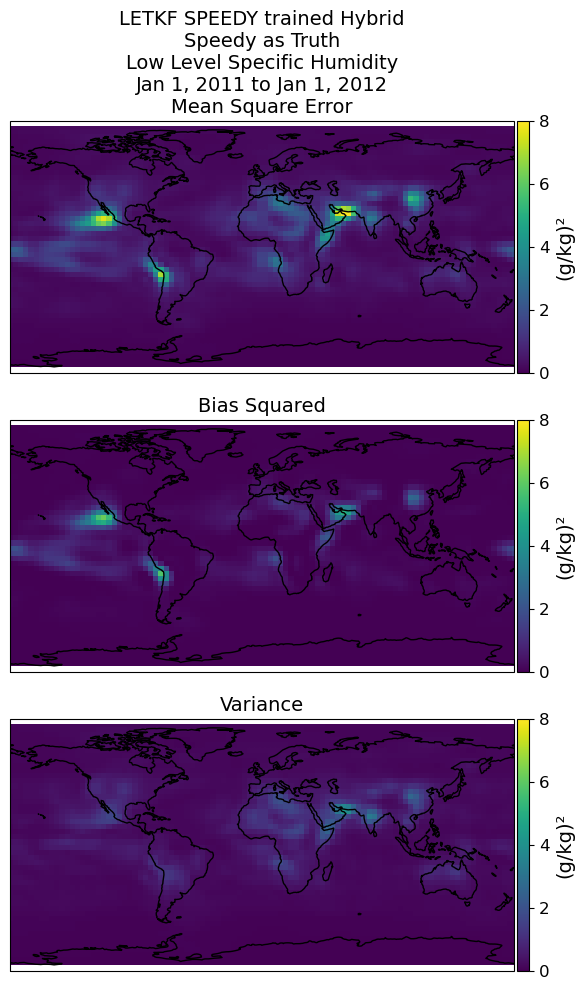

bias_hybrid_now_squared  [[0.0200693  0.02110696 0.02198446 ... 0.02363454 0.02108527 0.01992026]
 [0.01185578 0.00728943 0.00384993 ... 0.0151023  0.01333963 0.01262123]
 [0.03832762 0.0316865  0.02731701 ... 0.05565803 0.04810508 0.04873033]
 ...
 [0.22142895 0.23319008 0.20908728 ... 0.12967019 0.13750328 0.17861868]
 [0.1734668  0.16666809 0.15357021 ... 0.17807274 0.18436969 0.18051972]
 [0.06474797 0.06293964 0.06112128 ... 0.0707919  0.06888319 0.06711432]]
Map_of_level_0.95_variable_q_SPEEDY_trained_Hybrid_3_12_24.png


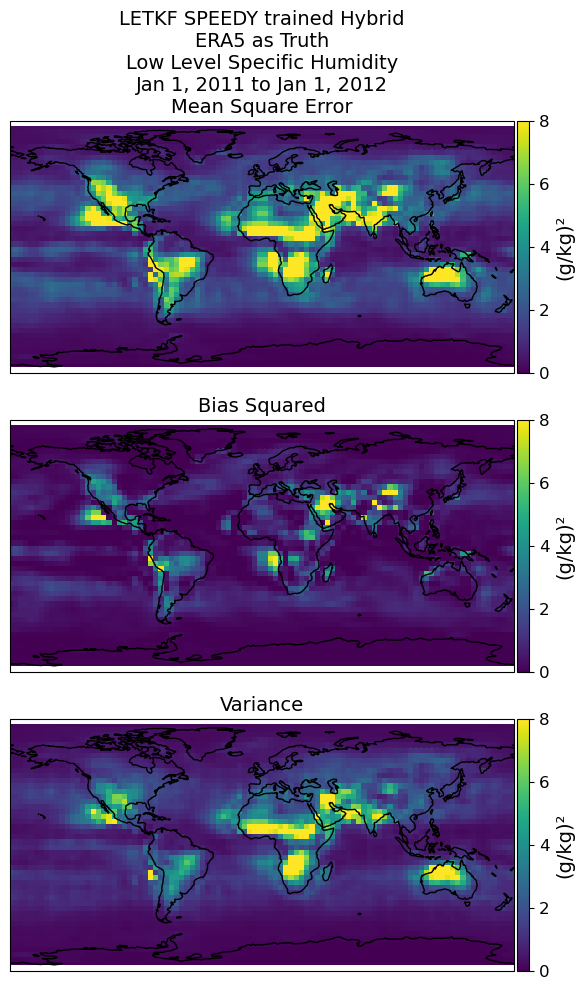

Map_of_level_0.95_variable_q_ERA5_trained_Hybrid_3_12_24.png


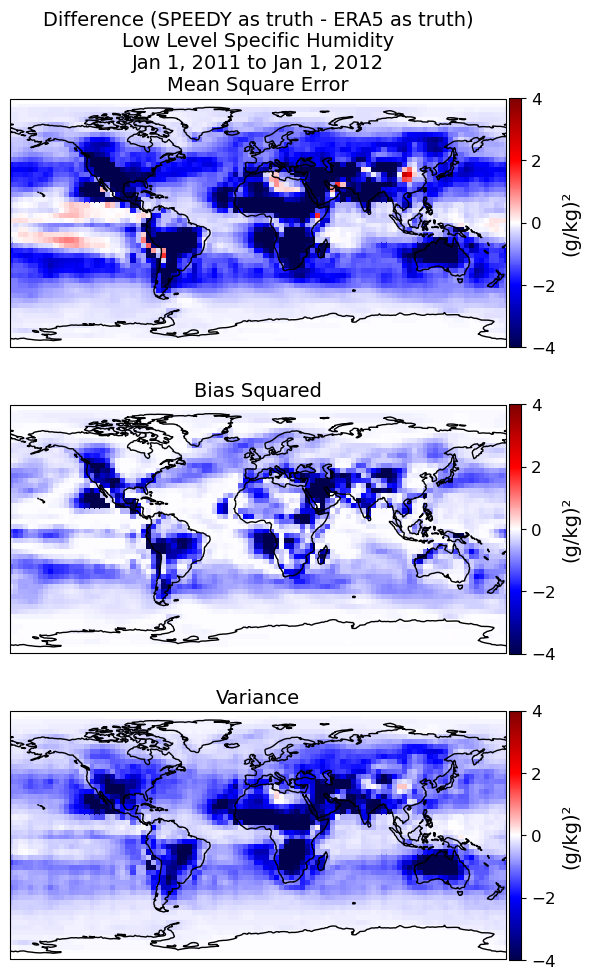

In [23]:
# TEST CELL an individual variable/level combination
rmse_time_series_plot_and_maps(.95,'q')

logp
you selected for variable = logp
at level = 0.95
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'ps' (lat: 48, lon: 96)>
array([[ 706.63525,  703.5768 ,  700.5189 , ...,  716.2559 ,  712.55383,
         709.4838 ],
       [ 723.36774,  716.2257 ,  712.1803 , ...,  744.87225,  737.21765,
         730.59265],
       [ 729.60345,  713.15265,  700.9723 , ...,  778.68823,  765.2656 ,
         748.1449 ],
       ...,
       [1018.6477 , 1018.21124, 1018.5965 , ..., 1019.9801 , 1020.1396 ,
        1019.5081 ],
       [1024.6915 , 1024.9567 , 1025.3234 , ..., 1023.3208 , 1023.9737 ,
        1024.4895 ],
       [1025.5682 , 1025.6561 , 1025.6825 , ..., 1025.1011 , 1025.1782 ,
        1025.2568 ]], dtype=float32)
Coordinates:
    time   

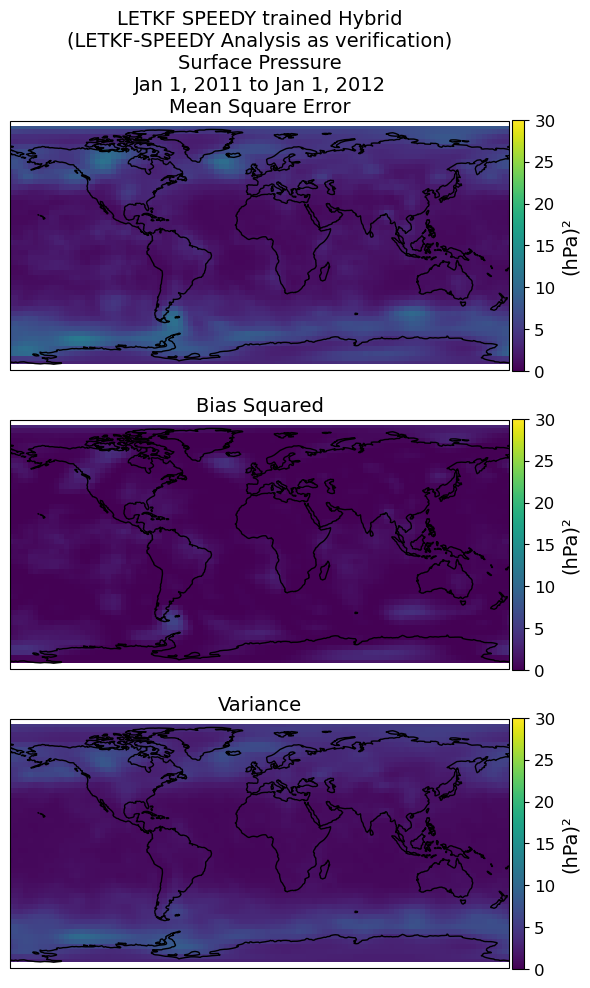

bias_hybrid_now_squared  [[3.40332373e+01 6.76947064e+01 1.12418136e+02 ... 2.69343042e-01
  9.48191619e-01 1.06350714e+01]
 [3.03774927e+02 1.35234555e+02 1.27453523e+01 ... 1.53135003e+03
  1.01384531e+03 5.73540862e+02]
 [6.97270997e+02 8.20332149e+02 1.02588661e+03 ... 2.07154518e-01
  2.21747985e+02 5.27124289e+02]
 ...
 [5.30707692e+02 6.91532656e+02 6.09337509e+02 ... 4.16680799e+02
  4.62757111e-01 1.96403948e+02]
 [2.77166143e+02 3.68403590e+02 4.04839455e+02 ... 1.10929999e+00
  3.95122724e+01 1.49265553e+02]
 [1.72311457e+02 1.74098274e+02 1.72483381e+02 ... 1.42616060e+02
  1.57892395e+02 1.70204471e+02]]
Map_of_level_0.95_variable_ps_SPEEDY_trained_Hybrid_3_12_24.png


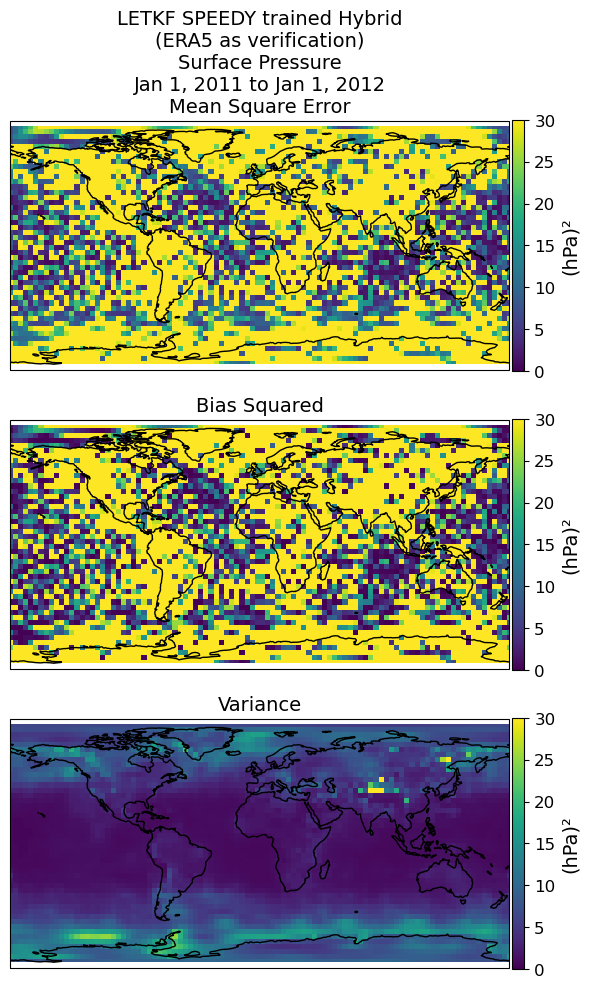

Map_of_level_0.95_variable_ps_ERA5_trained_Hybrid_3_12_24.png


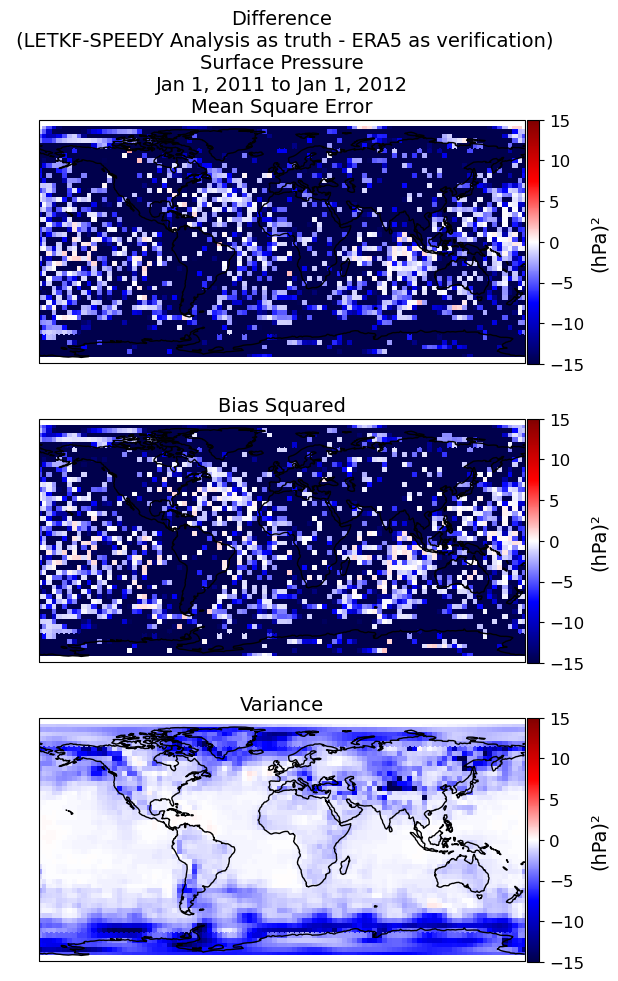

V-wind
you selected for variable = V-wind
at level = 0.2
made it to the for loop...
LOADING DATA...
Now its concatinating them all together...
Done concat and sortby Timestep...
era5 shape =  (1460, 48, 96)
speedy shape =  (1460, 48, 96)
hybrid shape =  (1460, 48, 96)
the smallest length is 1460
(1460, 48, 96)
(1460, 48, 96)
Test unit check:
<xarray.DataArray 'v' (lat: 48, lon: 96)>
array([[-0.697076, -1.02728 , -1.367197, ...,  0.380313, -0.032907, -0.379555],
       [-2.613001, -2.724056, -3.062883, ..., -2.193759, -2.53862 , -2.621226],
       [-3.114785, -3.26048 , -3.216159, ..., -1.45761 , -1.866138, -2.432457],
       ...,
       [-1.027906, -2.017979, -3.286185, ...,  1.457689,  0.668608, -0.181009],
       [-0.867295, -2.442718, -4.11816 , ...,  3.077409,  1.919865,  0.574095],
       [-3.854692, -4.975684, -6.080714, ..., -0.61546 , -1.658302, -2.738505]],
      dtype=float32)
Coordinates:
    time     datetime64[ns] 2011-01-01
  * lon      (lon) float64 0.0 3.75 7.5 11.25 15

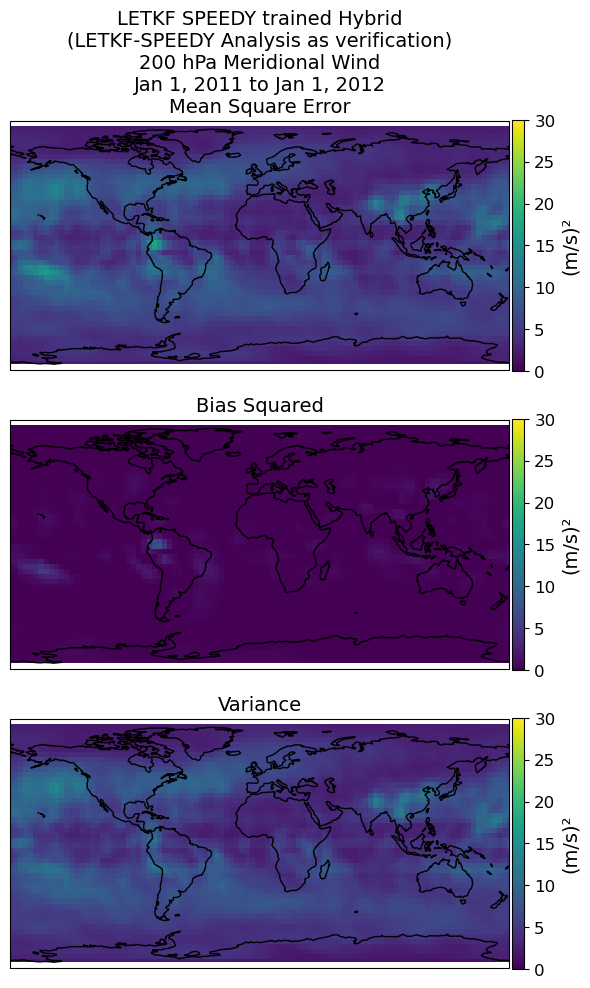

bias_hybrid_now_squared  [[0.04251999 0.03231648 0.0227857  ... 0.06047362 0.05943685 0.05047344]
 [0.02292497 0.03447374 0.04102422 ... 0.00720795 0.01042664 0.01657734]
 [0.17361201 0.16291637 0.11577154 ... 0.12278787 0.14430052 0.1717155 ]
 ...
 [0.00253636 0.04581335 0.14152366 ... 1.25541536 0.60923112 0.16562644]
 [0.29601502 0.16668262 0.08650292 ... 0.92408834 0.69865735 0.4835842 ]
 [0.40108398 0.38194657 0.36555682 ... 0.42129202 0.43212055 0.42663858]]
Map_of_level_0.2_variable_v_SPEEDY_trained_Hybrid_3_12_24.png


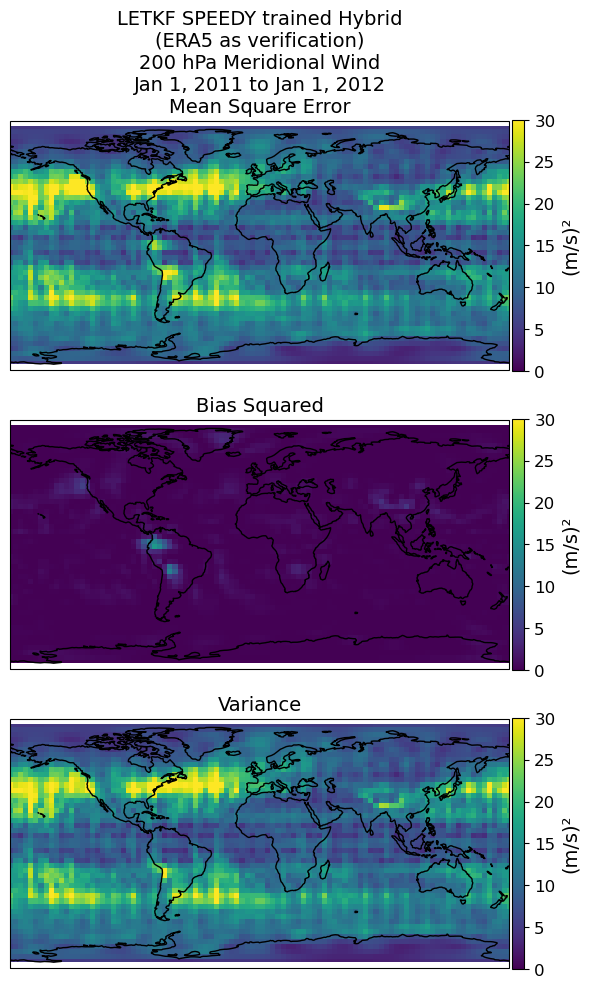

Map_of_level_0.2_variable_v_ERA5_trained_Hybrid_3_12_24.png


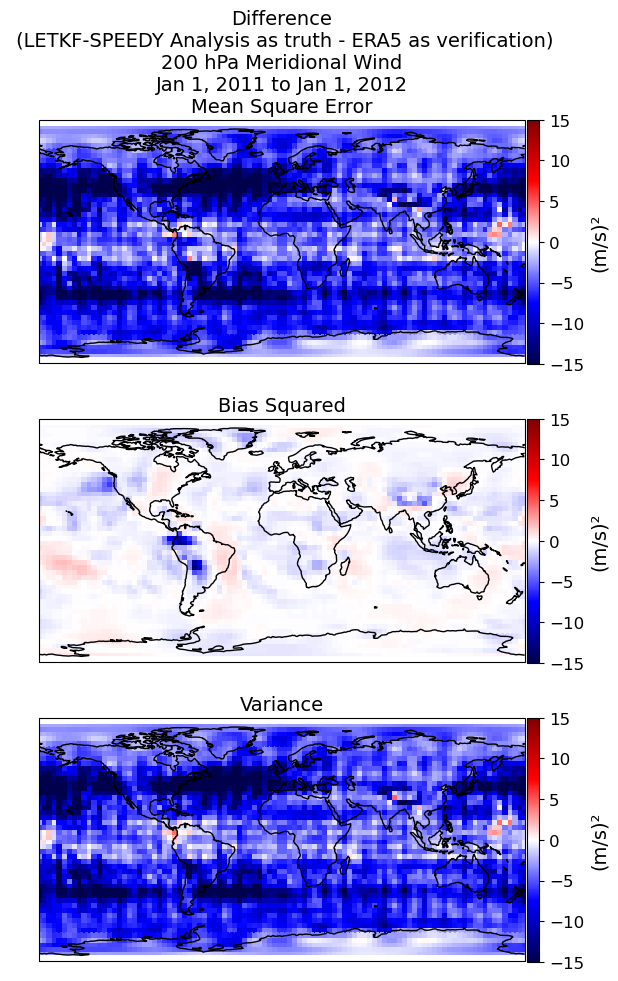

In [34]:
variable_list = ['ps']
for i in variable_list:
    
    rmse_time_series_plot_and_maps(.95,i)
    
rmse_time_series_plot_and_maps(.2,'v')